In [ ]:
import numpy as np
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import time
np.random.seed(42)

# Loading Data

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# Building Train and Validation sets

In [ ]:
# Generating the training and validation indices using random splitting
ind_valid = np.random.choice(X_train_valid.shape[0], math.floor(0.15*X_train_valid.shape[0]), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
(p_train, p_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]

In [ ]:
print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)

print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)

Train Data Shape: 
Input Shape: (1798, 22, 1000)
Labels Shape: (1798,)
Persons Shape: (1798, 1)

Validation Data Shape: 
Input Shape: (317, 22, 1000)
Labels Shape: (317,)
Persons Shape: (317, 1)


In [ ]:
# for naming consistency
p_test = person_test

Note:

Train Data: X_train, y_train, p_train

Validation Data: X_test, y_test, p_test

Test Data: X_valid, y_valid, p_valid

# Basic Data Processing

In [ ]:
def train_data_prep(X,y,p,sub_sample=2,average=2,noise=True):

    # Adjusting labels
    y -= 769

    total_X = None
    total_y = None
    total_p = None

    # Cropping the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data in time dimension (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    total_p = p
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging original data + adding noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Augmenting averaged data with noise to max pool filtered data
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.vstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + optionally adding noise
    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        # augmenting subsampled plus optionally noise added data
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.vstack((total_p, p))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    print('Shape of P:',total_p.shape)

    return total_X, total_y, total_p


def test_data_prep(X, y, p, sub_sample=2):

    #Adjusting labels
    total_y = y - 769
    total_p = p
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X, total_y, total_p

In [ ]:
print('Train prep:')
X_train, y_train, p_train = train_data_prep(X_train, y_train, p_train)
print()
print('Validation prep:')
X_valid, y_valid, p_valid = train_data_prep(X_valid, y_valid, p_valid)
print()
print('Test prep:')
X_test, y_test, p_test = test_data_prep(X_test, y_test, p_test)

Train prep:
Shape of X after trimming: (1798, 22, 800)
Shape of X after maxpooling: (1798, 22, 400)
Shape of X after averaging+noise and concatenating: (3596, 22, 400)
Shape of X after subsampling and concatenating: (7192, 22, 400)
Shape of Y: (7192,)
Shape of P: (7192, 1)

Validation prep:
Shape of X after trimming: (317, 22, 800)
Shape of X after maxpooling: (317, 22, 400)
Shape of X after averaging+noise and concatenating: (634, 22, 400)
Shape of X after subsampling and concatenating: (1268, 22, 400)
Shape of Y: (1268,)
Shape of P: (1268, 1)

Test prep:
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)


Confirming validation is still around 15% of total train and validation points after preprocessing.

In [ ]:
1268/(1268+7192)

0.14988179669030732

In [ ]:
# Confirming labels look good - should be between 0 and 3
print(y_train[0])
print(y_valid[0])
print(y_test[0])

2
0
1


In [ ]:
print('Shape of all data after preprocessing')
print()

print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)
print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)
print()

print("Test Data Shape: ")
print("Input Shape:", X_test.shape)
print("Labels Shape:", y_test.shape)
print("Persons Shape:", p_test.shape)
print()

Shape of all data after preprocessing

Train Data Shape: 
Input Shape: (7192, 22, 400)
Labels Shape: (7192,)
Persons Shape: (7192, 1)

Validation Data Shape: 
Input Shape: (1268, 22, 400)
Labels Shape: (1268,)
Persons Shape: (1268, 1)

Test Data Shape: 
Input Shape: (443, 22, 400)
Labels Shape: (443,)
Persons Shape: (443, 1)



# Formatting Data Correctly for CNN model

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

Shape of training labels after categorical conversion: (7192, 4)
Shape of validation labels after categorical conversion: (1268, 4)
Shape of test labels after categorical conversion: (443, 4)


In [ ]:
# Ensuring all labels look good - should look like one hot encoding
print(y_train[0])
print(y_valid[0])
print(y_test[0])

[0. 0. 1. 0.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]


In [ ]:
# Adding width of the segment to be 1 for all inputs
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:', X_train.shape)
print('Shape of validation set after adding width info:', X_valid.shape)
print('Shape of test set after adding width info:', X_test.shape)

Shape of training set after adding width info: (7192, 22, 400, 1)
Shape of validation set after adding width info: (1268, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)


In [ ]:
# Reshaping the training, validation, and test datasets
X_train = np.swapaxes(X_train, 1,3)
X_train = np.swapaxes(X_train, 1,2)
X_valid = np.swapaxes(X_valid, 1,3)
X_valid = np.swapaxes(X_valid, 1,2)
X_test = np.swapaxes(X_test, 1,3)
X_test = np.swapaxes(X_test, 1,2)
print('Shape of training set after dimension reshaping:', X_train.shape)
print('Shape of validation set after dimension reshaping:', X_valid.shape)
print('Shape of test set after dimension reshaping:', X_test.shape)

Shape of training set after dimension reshaping: (7192, 400, 1, 22)
Shape of validation set after dimension reshaping: (1268, 400, 1, 22)
Shape of test set after dimension reshaping: (443, 400, 1, 22)


In [ ]:
print('Shape of all data after formatting')
print()

print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)
print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)
print()

print("Test Data Shape: ")
print("Input Shape:", X_test.shape)
print("Labels Shape:", y_test.shape)
print("Persons Shape:", p_test.shape)
print()

Shape of all data after formatting

Train Data Shape: 
Input Shape: (7192, 400, 1, 22)
Labels Shape: (7192, 4)
Persons Shape: (7192, 1)

Validation Data Shape: 
Input Shape: (1268, 400, 1, 22)
Labels Shape: (1268, 4)
Persons Shape: (1268, 1)

Test Data Shape: 
Input Shape: (443, 400, 1, 22)
Labels Shape: (443, 4)
Persons Shape: (443, 1)



Now I will convert all this data to tf vectors

In [ ]:
# construct the dataset from the NumPy arrays
train_TF = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_TF = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_TF = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# batch and shuffle
train_TF = train_TF.shuffle(8000).batch(64)
valid_TF = valid_TF.shuffle(8000).batch(64)
test_TF = test_TF.shuffle(8000).batch(64)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Generating Subject 1 Data

In [ ]:
# Getting Training, Testing, Validation indices for subject 1
subject_indices_test = np.where(p_test[:, 0] == 0)[0]
subject_indices_train = np.where(p_train[:, 0] == 0)[0]
subject_indices_valid = np.where(p_valid[:, 0] == 0)[0]

print('Subject 1 train num:', len(subject_indices_train))
print('Subject 1 valid num:', len(subject_indices_valid))
print('Subject 1 test num:', len(subject_indices_test))

Subject 1 train num: 828
Subject 1 valid num: 120
Subject 1 test num: 50


In [ ]:
120/(120+828)

0.12658227848101267

The above seem like good proportions to move on with for optimizing subject 1's classification accuracy.

In [ ]:
# Getting train, test, and validation data for subject 1
x_subject1_train_data = X_train[subject_indices_train]
y_subject1_train_data = y_train[subject_indices_train]

x_subject1_valid_data = X_valid[subject_indices_valid]
y_subject1_valid_data = y_valid[subject_indices_valid]

x_subject1_test_data = X_test[subject_indices_test]
y_subject1_test_data = y_test[subject_indices_test]

print('Training Data for subject 1 dimensions')
print(x_subject1_train_data.shape)
print(y_subject1_train_data.shape)

print('Validation Data for subject 1 dimensions')
print(x_subject1_valid_data.shape)
print(y_subject1_valid_data.shape)

print('Testing Data for subject 1 dimensions')
print(x_subject1_test_data.shape)
print(y_subject1_test_data.shape)

Training Data for subject 1 dimensions
(828, 400, 1, 22)
(828, 4)
Validation Data for subject 1 dimensions
(120, 400, 1, 22)
(120, 4)
Testing Data for subject 1 dimensions
(50, 400, 1, 22)
(50, 4)


In [ ]:
# construct the dataset from the NumPy arrays
s1_train_TF = tf.data.Dataset.from_tensor_slices((x_subject1_train_data, y_subject1_train_data))
s1_valid_TF = tf.data.Dataset.from_tensor_slices((x_subject1_valid_data, y_subject1_valid_data))
s1_test_TF = tf.data.Dataset.from_tensor_slices((x_subject1_test_data, y_subject1_test_data))

# batch and shuffle
s1_train_TF = s1_train_TF.shuffle(1024).batch(32)
s1_valid_TF = s1_valid_TF.shuffle(1024).batch(32)
s1_test_TF = s1_test_TF.shuffle(1024).batch(32)

# Helper Functions

In [ ]:
def plotAccuracyLossHistory(model_results, intro):
  print(intro)
  print()
  # Plotting accuracy trajectory
  plt.plot(model_results.history['accuracy'])
  plt.plot(model_results.history['val_accuracy'])
  plt.title('CNN Accuracy trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  # Plotting loss trajectory
  plt.plot(model_results.history['loss'],'o')
  plt.plot(model_results.history['val_loss'],'o')
  plt.title('CNN Loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

# Optimizing classification accuracy using baseline CNN model

The baseline CNN model is a slightly modified and simplified version of the CNN model used for classifying EEG signals in the paper: 'Deep learning with convolutional neural networks for brain mapping and decoding of movement-related information from the human EEG' by Schirrmeister et al.

In [ ]:
def generateBaselineModel():
  # Building the CNN model using sequential class
  model = Sequential()

  # Conv. block 1
  model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(400, 1, 22)))
  # padding same and stride 1 (default) in conv layer: output size = input size
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  # default stride is None in pooling layer: stride = pool size
  #  padding in pooling layer is "same": output_shape = math.floor((input_shape - 1) / strides) + 1
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 2
  model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 3
  model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 4
  model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output layer with Softmax activation
  model.add(Flatten()) # Flattens the input
  model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return model

## **Training on subject 1**

In [ ]:
model = generateBaselineModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 134, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        12550     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 1, 50)         0

In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

In [ ]:
# Training the model on above data
model_results_subject1 = model.fit(x=s1_train_TF, validation_data=s1_valid_TF, epochs=50, verbose=True)

Epoch 1/50
26/26 [==============================] - 8s 43ms/step - loss: 2.0092 - accuracy: 0.3635 - val_loss: 5.2056 - val_accuracy: 0.3333
Epoch 2/50
26/26 [==============================] - 0s 10ms/step - loss: 1.9197 - accuracy: 0.3889 - val_loss: 4.2261 - val_accuracy: 0.2667
Epoch 3/50
26/26 [==============================] - 0s 8ms/step - loss: 1.5756 - accuracy: 0.4638 - val_loss: 3.9503 - val_accuracy: 0.2750
Epoch 4/50
26/26 [==============================] - 0s 8ms/step - loss: 1.2230 - accuracy: 0.5870 - val_loss: 1.7292 - val_accuracy: 0.4083
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 0.9493 - accuracy: 0.6389 - val_loss: 1.1305 - val_accuracy: 0.5250
Epoch 6/50
26/26 [==============================] - 0s 8ms/step - loss: 0.8816 - accuracy: 0.6812 - val_loss: 1.1510 - val_accuracy: 0.6250
Epoch 7/50
26/26 [==============================] - 0s 8ms/step - loss: 0.6962 - accuracy: 0.7222 - val_loss: 1.0030 - val_accuracy: 0.5750
Epoch 8/50
26/26 [

Training of baseline CNN model on subject 1 data



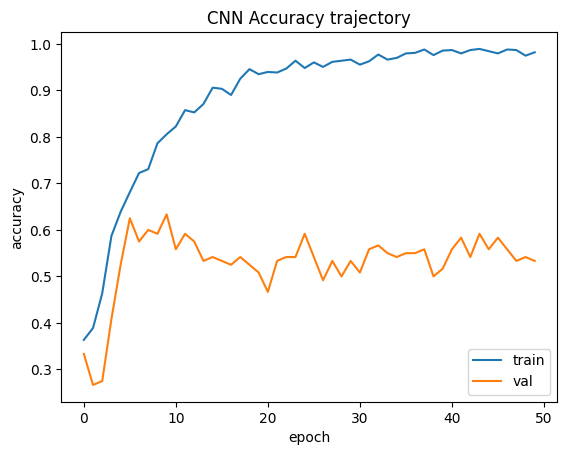

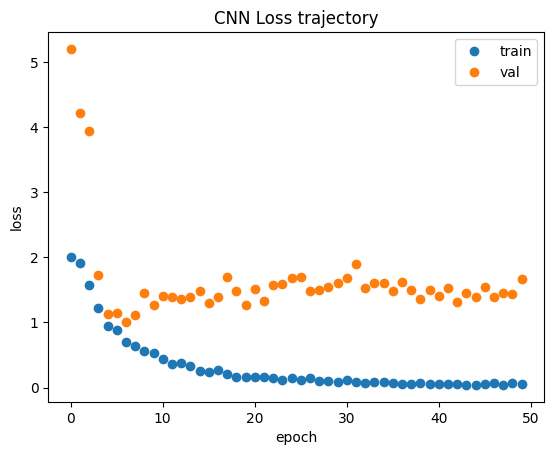

Test accuracy for Subject 1: 0.6200000047683716


In [ ]:
plotAccuracyLossHistory(model_results_subject1, 'Training of baseline CNN model on subject 1 data')
# Evaluating on test set
score = model.evaluate(x=s1_test_TF, verbose=0)
print('Test accuracy for Subject 1:', score[1])

## **Training on all subjects.**

In [ ]:
model = generateBaselineModel()
model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

# Training the model on all data
model_results_all = model.fit(x=train_TF, validation_data=valid_TF, epochs=50, verbose=True)

Epoch 1/50
113/113 [==============================] - 5s 15ms/step - loss: 1.9144 - accuracy: 0.3222 - val_loss: 1.4266 - val_accuracy: 0.3454
Epoch 2/50
113/113 [==============================] - 1s 9ms/step - loss: 1.5354 - accuracy: 0.3731 - val_loss: 1.2830 - val_accuracy: 0.3991
Epoch 3/50
113/113 [==============================] - 1s 11ms/step - loss: 1.3629 - accuracy: 0.4245 - val_loss: 1.2234 - val_accuracy: 0.4432
Epoch 4/50
113/113 [==============================] - 1s 11ms/step - loss: 1.2192 - accuracy: 0.4840 - val_loss: 1.2421 - val_accuracy: 0.4637
Epoch 5/50
113/113 [==============================] - 1s 9ms/step - loss: 1.1223 - accuracy: 0.5296 - val_loss: 1.1940 - val_accuracy: 0.4748
Epoch 6/50
113/113 [==============================] - 1s 9ms/step - loss: 1.0542 - accuracy: 0.5648 - val_loss: 1.1214 - val_accuracy: 0.4929
Epoch 7/50
113/113 [==============================] - 1s 9ms/step - loss: 0.9948 - accuracy: 0.5905 - val_loss: 1.1059 - val_accuracy: 0.5260
Epo

Training of baseline CNN model on all data



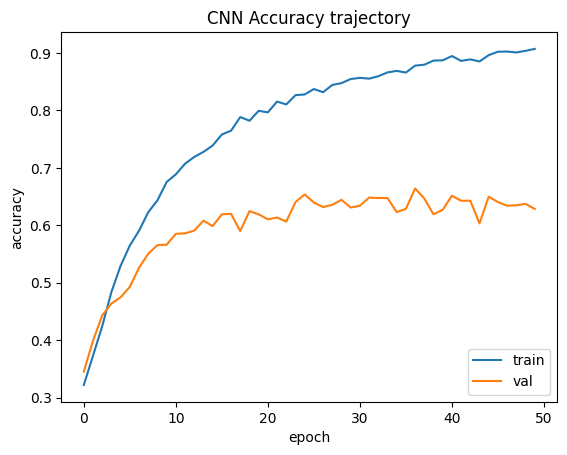

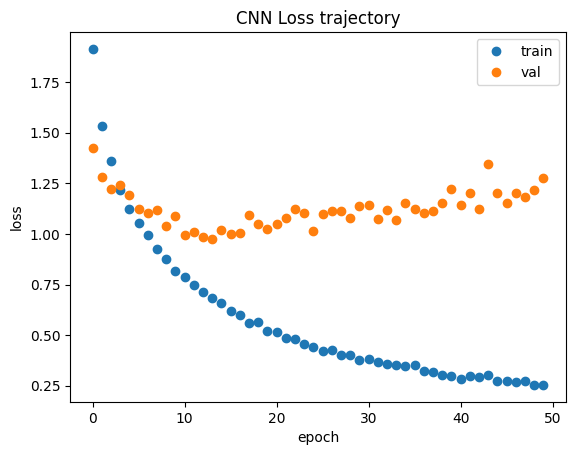

Test accuracy for Subject 1:  0.47999998927116394


In [ ]:
plotAccuracyLossHistory(model_results_all, 'Training of baseline CNN model on all data')
# Evaluating on test set
score = model.evaluate(x=s1_test_TF, verbose=0)
print('Test accuracy for Subject 1: ', score[1])

**Train on all subjects and test on all subjects**

In [ ]:
# Evaluating on test set
score = model.evaluate(x=test_TF, verbose=0)
print('Test accuracy of the basic CNN model: ', score[1])

Test accuracy of the basic CNN model:  0.6546275615692139


## Summary

Summary of training baseline CNN model on subject 1 data:

*   The validation accuracy and validation loss graphs seem to indicate overfitting as they don't increase or decrease respectively along with training metrics after first few epochs.
*   Classification Accuracy on subject 1 test data: 0.62

Summary of training baseline CNN model on all data:


*   The validation accuracy and validation loss graphs seem to indicate overfitting as they don't increase or decrease respectively along with training metrics after first few epochs. Validation loss also seems to increase towards the end.
*   Classification Accuracy on subject 1 test data: 0.48
*   Classification Accuracy on all test data: 0.655


Since overfitting is observed there may be scope for improvement with regards to validation and test accuracies. So will optimize further in below section.

# Optimizing classification accuracy using optimized model

To optimize I decided to use 3 convolutional blocks instead 4 (to try and prevent overfitting). I also used 2D smaller Kernel sizes for the initial layers. In order to avoid undefitting I increased the number of filters in the 3 convolutional blocks. Intuition for the last 2 updates comes from observations in ZFNet case study.

In [ ]:
def generateOptimizedModel(input_shape=(400,1,22)):
  # Building the CNN model using sequential class
  model = Sequential()

  # Conv. block 1
  model.add(Conv2D(filters=50, kernel_size=(3,3), padding='same', activation='elu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Conv. block 2
  model.add(Conv2D(filters=100, kernel_size=(3,3), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Conv. block 3
  model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Output layer with Softmax activation
  model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  model.add(Dense(4, activation='softmax'))

  return model

## **Train on subject 1**

In [ ]:
optim_model = generateOptimizedModel()
optim_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 400, 1, 50)        9950      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 134, 1, 50)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 134, 1, 50)        200       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 134, 1, 50)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 134, 1, 100)       45100     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 1, 100)       

In [ ]:
# Compiling the model
optim_model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

In [ ]:
optim_model_results_subject1 = optim_model.fit(x=s1_train_TF, validation_data=s1_valid_TF, epochs=50, verbose=True)

Epoch 1/50
26/26 [==============================] - 5s 66ms/step - loss: 2.2274 - accuracy: 0.3587 - val_loss: 2.1690 - val_accuracy: 0.3250
Epoch 2/50
26/26 [==============================] - 0s 9ms/step - loss: 1.5734 - accuracy: 0.5109 - val_loss: 1.8417 - val_accuracy: 0.3083
Epoch 3/50
26/26 [==============================] - 0s 9ms/step - loss: 1.2959 - accuracy: 0.5616 - val_loss: 1.3775 - val_accuracy: 0.4167
Epoch 4/50
26/26 [==============================] - 0s 9ms/step - loss: 1.0617 - accuracy: 0.6425 - val_loss: 1.1820 - val_accuracy: 0.4583
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.8431 - accuracy: 0.7065 - val_loss: 1.2944 - val_accuracy: 0.5833
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.7145 - accuracy: 0.7572 - val_loss: 1.4956 - val_accuracy: 0.4667
Epoch 7/50
26/26 [==============================] - 0s 13ms/step - loss: 0.5320 - accuracy: 0.7886 - val_loss: 1.7924 - val_accuracy: 0.4583
Epoch 8/50
26/26

Optimized CNN training on Subject 1 data



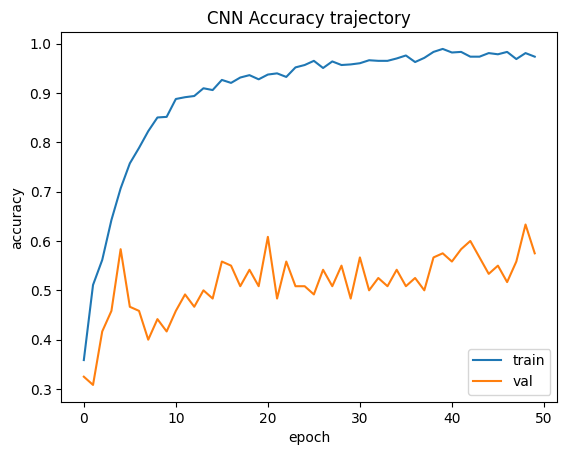

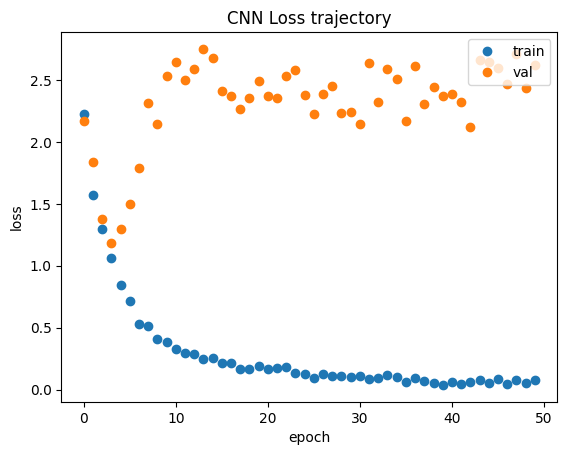

Test accuracy of the optim CNN model for Subject 1: 0.5600000023841858


In [ ]:
plotAccuracyLossHistory(optim_model_results_subject1, 'Optimized CNN training on Subject 1 data')
# Evaluating on test set
score = optim_model.evaluate(x=s1_test_TF, verbose=0)
print('Test accuracy of the optim CNN model for Subject 1:', score[1])

## **Train on all subjects**

In [ ]:
optim_model = generateOptimizedModel()
# Compiling the model
optim_model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])
optim_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 400, 1, 50)        9950      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 134, 1, 50)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_11 (Ba  (None, 134, 1, 50)        200       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 134, 1, 50)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 134, 1, 100)       45100     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 45, 1, 100)       

In [ ]:
start_time = time.time()
# Training the model on all data
optim_model_results_all = optim_model.fit(x=train_TF, validation_data=valid_TF, epochs=100, verbose=True)
end_time = time.time()

Epoch 1/100
113/113 [==============================] - 6s 18ms/step - loss: 2.0680 - accuracy: 0.3414 - val_loss: 1.3075 - val_accuracy: 0.4148
Epoch 2/100
113/113 [==============================] - 1s 10ms/step - loss: 1.5878 - accuracy: 0.4328 - val_loss: 1.2330 - val_accuracy: 0.4519
Epoch 3/100
113/113 [==============================] - 1s 10ms/step - loss: 1.3775 - accuracy: 0.4832 - val_loss: 1.2379 - val_accuracy: 0.4629
Epoch 4/100
113/113 [==============================] - 1s 11ms/step - loss: 1.2370 - accuracy: 0.5172 - val_loss: 1.3045 - val_accuracy: 0.4850
Epoch 5/100
113/113 [==============================] - 1s 12ms/step - loss: 1.1277 - accuracy: 0.5578 - val_loss: 1.1274 - val_accuracy: 0.5426
Epoch 6/100
113/113 [==============================] - 1s 12ms/step - loss: 1.0646 - accuracy: 0.5873 - val_loss: 1.1924 - val_accuracy: 0.5347
Epoch 7/100
113/113 [==============================] - 1s 10ms/step - loss: 0.9994 - accuracy: 0.6096 - val_loss: 1.0430 - val_accuracy:

Training time of CNN model on all data: 138.97355723381042 seconds
Optimized CNN training on all data



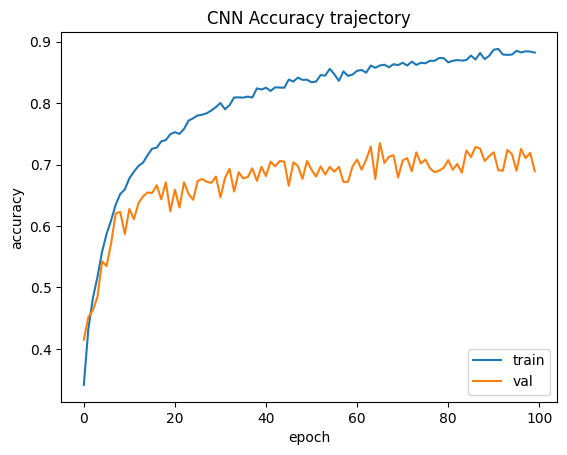

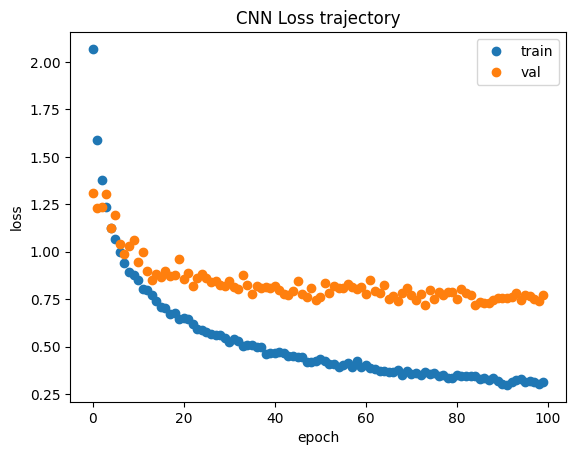

In [ ]:
training_time = end_time - start_time
print(f"Training time of CNN model on all data: {training_time} seconds")
plotAccuracyLossHistory(optim_model_results_all, 'Optimized CNN training on all data')

In [ ]:
# Evaluating on test set
score = optim_model.evaluate(x=s1_test_TF, verbose=0)
print('Test accuracy of the optim CNN model for subject 1 test data:', score[1])

Test accuracy of the optim CNN model for subject 1 test data: 0.6800000071525574


**Train on all subjects and test on all subjects**

In [ ]:
score = optim_model.evaluate(x=test_TF, verbose=0)
print('Test accuracy of the optim CNN model for all test data:', score[1])

Test accuracy of the optim CNN model for all test data: 0.7065462470054626


## Summary

Summary of training optimized CNN model on subject 1 data:

*   Classification Accuracy on subject 1 test data: 0.56

Summary of training optimized CNN model on all data:

*   Classification Accuracy on subject 1 test data: 0.68
*   Classification Accuracy on all test data: 0.70

There still seem to be signs of overfitting (especially while training on just subject 1 data possibly due to a small number of datapoints). However, at least the validation accuracies reach higher values and validation losses reach lower values. Also the testing accuracies look better for the optimized model trained on all data and tested on all data.

The optimized model trained on all data seems to perform better for classifying subject 1 test data compared to the optimized model trained on just subject 1 data. This is potentially because multitasking (trying to make the model good as classifying for any subject) regularization helps the model genralize better for the particular task (classifying subject 1's data).

# Evaluating classification accuracy as a function of time

In [ ]:
# Helper function to generate crops of data in time series
def generateCroppedDataSet(train_x, valid_x, test_x, begin, end):
  c_tr_x = train_x[:, begin:end, :, :]
  c_v_x = valid_x[:, begin:end, :, :]
  c_te_x = test_x[:, begin:end, :, :]
  return c_tr_x, c_v_x, c_te_x

In [ ]:
def generateTensors(train, valid, test):
  # construct the dataset from the NumPy arrays
  train = tf.data.Dataset.from_tensor_slices((train, y_train))
  valid = tf.data.Dataset.from_tensor_slices((valid, y_valid))
  test = tf.data.Dataset.from_tensor_slices((test, y_test))

  # batch and shuffle
  train = train.shuffle(8000).batch(64)
  valid = valid.shuffle(8000).batch(64)
  test = test.shuffle(8000).batch(64)

  return train, valid, test

In [ ]:
# Confirming that above is working:
c_tr_x, c_v_x, c_te_x = generateCroppedDataSet(X_train, X_valid, X_test, 200, 400)
# Expected to have dimension: (datapoints, 200, 1, 22)
print(c_tr_x.shape, c_v_x.shape, c_te_x.shape)

(7192, 200, 1, 22) (1268, 200, 1, 22) (443, 200, 1, 22)


In [ ]:
# Confirming labels shape
print(y_train.shape, y_valid.shape, y_test.shape)

(7192, 4) (1268, 4) (443, 4)


## Generating results for various time frames

Evaluating increasing time frames of processed data:


*   0-100
*   0-200
*   0-300
*   0-400

All the data is used in this evaluation (not particular to any subject). Also the optimized CNN model is used. A model is evaluated on each time frame for exactly 50 epochs.





Analyzing the frame (0, 100)
(7192, 100, 1, 22) (1268, 100, 1, 22) (443, 100, 1, 22)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 100, 1, 50)        9950      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 34, 1, 50)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_14 (Ba  (None, 34, 1, 50)         200       
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 34, 1, 50)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 34, 1, 100)        45100     
                                   

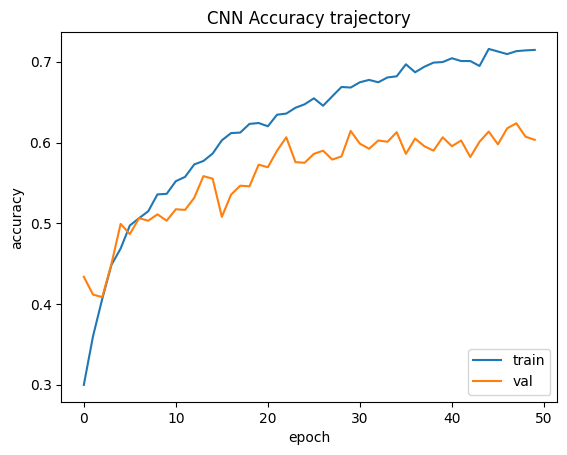

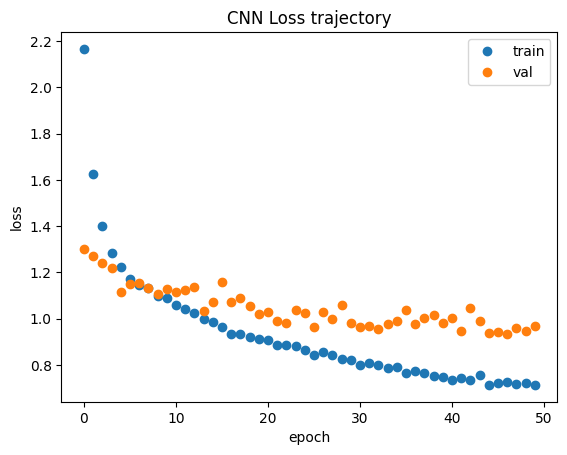

Test accuracy of model: 0.6388261914253235


Analyzing the frame (0, 200)
(7192, 200, 1, 22) (1268, 200, 1, 22) (443, 200, 1, 22)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 200, 1, 50)        9950      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 67, 1, 50)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 67, 1, 50)         200       
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 67, 1, 50)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 67, 1, 100)        4

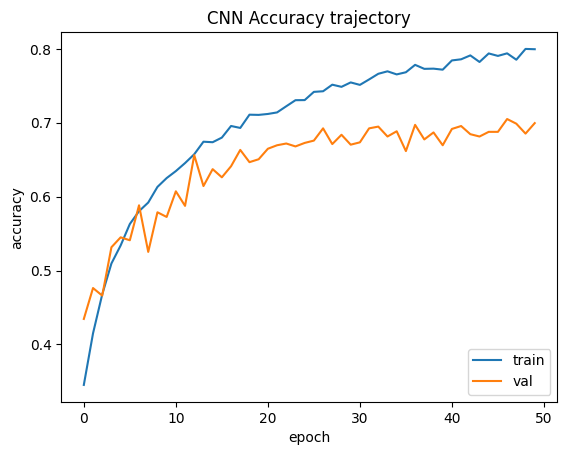

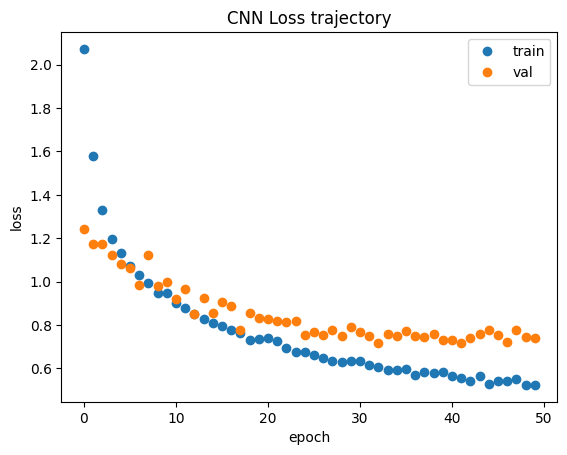

Test accuracy of model: 0.7268623113632202


Analyzing the frame (0, 300)
(7192, 300, 1, 22) (1268, 300, 1, 22) (443, 300, 1, 22)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 300, 1, 50)        9950      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 100, 1, 50)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 100, 1, 50)        200       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 100, 1, 50)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 1, 100)       4

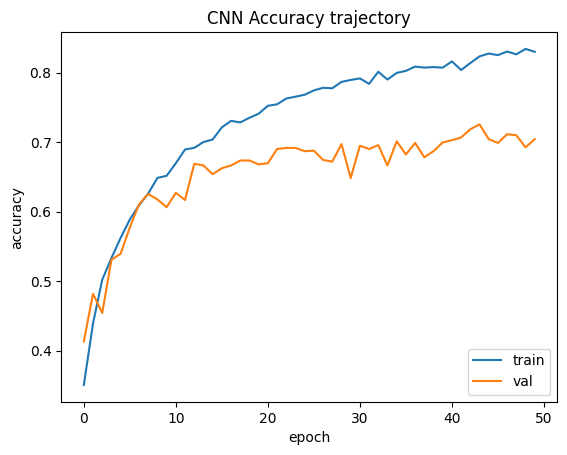

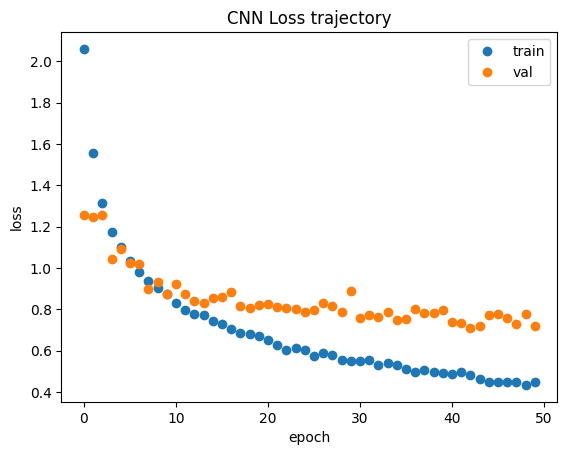

Test accuracy of model: 0.7268623113632202


Analyzing the frame (0, 400)
(7192, 400, 1, 22) (1268, 400, 1, 22) (443, 400, 1, 22)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 400, 1, 50)        9950      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 134, 1, 50)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_23 (Ba  (None, 134, 1, 50)        200       
 tchNormalization)                                               
                                                                 
 dropout_23 (Dropout)        (None, 134, 1, 50)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 134, 1, 100)       4

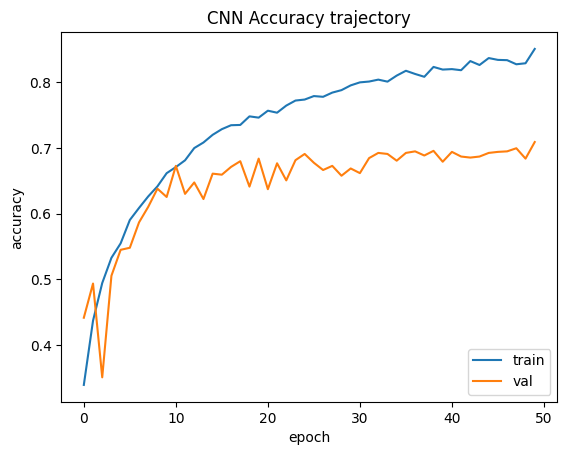

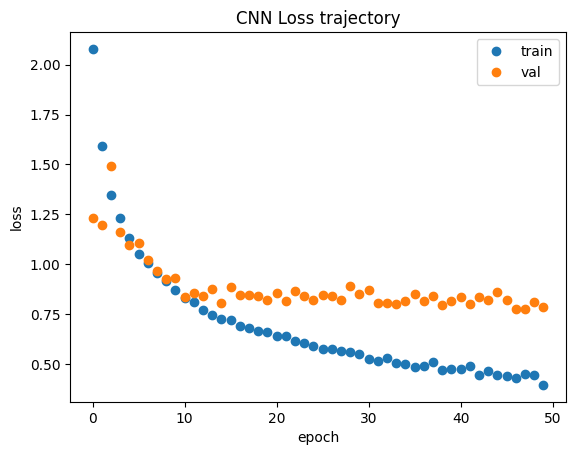

Test accuracy of model: 0.715575635433197




In [ ]:
test_acc = []
for end in [100, 200, 300, 400]:
  time_frame = (0, end)
  print('Analyzing the frame', time_frame)
  c_tr_x, c_v_x, c_te_x = generateCroppedDataSet(X_train, X_valid, X_test, 0, end)
  print(c_tr_x.shape, c_v_x.shape, c_te_x.shape)
  train, valid, test = generateTensors(c_tr_x, c_v_x, c_te_x)
  # We have data now, so we need to train a model
  c_model = generateOptimizedModel(input_shape=(end, 1, 22))
  c_model.summary()
  c_model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])
  c_model_results = c_model.fit(x=train, validation_data=valid, epochs=50, verbose=True)
  plotAccuracyLossHistory(c_model_results, 'Model Training')
  score = c_model.evaluate(x=test, verbose=0)
  print('Test accuracy of model:', score[1])
  test_acc.append(score[1])
  print()
  print()

## Summary


For the last three time frames in the processed data (0-200, 0-300, 0-400) the final test accuracy seems to cross 70% and also some of the epoch cross 70% validation accuracy.

Although model trained on the time frame 0-100 is not as good, it still gives a reasonable validation accuracies of a little over 60% during the final epochs and a final test accuracy of 64%.

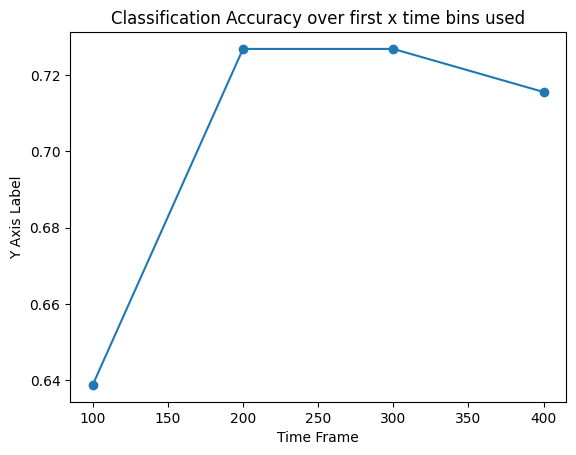

In [ ]:
x_values = [100, 200, 300, 400]
plt.plot(x_values, test_acc, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Time Frame')
plt.ylabel('Y Axis Label')
plt.title('Classification Accuracy over first x time bins used')

# Show plot
plt.show()

The test time classification accuracy is pretty good even after just considering the first 200 time bins in the processed data. These 200 time bins roughly correspond to the first 400 out of 1000 time bins in the original data. This is consistent with data analysis in EEG_loading notebook where the electrode signals seem to become noise after first 500 out of 1000 time bins.